# DELE CA2 Section A (GAN)
### Team : idk
### Name : Rejey Ezekiel & Qing Yang
### Class : DAAA/FT/2A/01

In [5]:
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import Concatenate
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU
import numpy as np
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Reshape,BatchNormalization, Activation, Input, LeakyReLU, Dropout, Flatten, Conv2DTranspose
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate, shift

Note: you may need to restart the kernel to use updated packages.


In [6]:
# List physical GPUs and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('emnist-letters-train.csv', delimiter=',', header=None)

In [8]:
df = df[df[0] != -1]

In [9]:
# Define the mapping dictionary
mapping = {1: 0, 
           2: 1, 
           3: 2, 
           4: 3, 
           5: 4, 
           6: 5, 
           7: 6, 
           8: 7, 
           9: 8, 
           10: 9, 
           11: 10, 
           12: 11, 
           13: 12, 
           14: 13, 
           15: 14, 
           16: 15, 
           17: 16, 
           18: 17, 
           19: 18, 
           20: 19, 
           21: 20, 
           22: 21, 
           23: 22, 
           24: 23, 
           25: 24, 
           26: 25, 
           27: 26}

        # Map the labels column to its corresponding value
df[0] = df[0].map(mapping)

In [10]:
y_pre = np.array(df.iloc[:,0].values)
y_pre = pd.Categorical(y_pre)
X = np.array(df.iloc[:,1:].values)
X = X.reshape(-1,28,28,1)
preprocessed = []
for image in X:
    rotated_image = rotate(image, 90, reshape=False)
    flipped_image = np.flipud(rotated_image)
    preprocessed.append(flipped_image)
X_pre = np.array(preprocessed)
X = X_pre
X = X.astype('float32')
X_pre = (X - 127.5) / 127.5

In [11]:
print(f'y_pre\n{y_pre.unique()}')

y_pre
[22, 6, 15, 14, 16, ..., 19, 8, 5, 11, 0]
Length: 26
Categories (26, int64): [0, 1, 2, 3, ..., 22, 23, 24, 25]


# DCGAN BaseModel

In [27]:
class DCGAN():
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        optimizer = Adam(0.0002, 0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        
        # The discriminator takes generated images as input and
        # determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',optimizer=optimizer)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(256 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 256)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(64, (3,3), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same", activation='tanh'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)


    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('Improved DCGAN', exist_ok=True)
        fig.savefig("Improved DCGAN/DCGAN_{:d}.png".format(epoch))
        plt.close()
        
    def train(self, epochs, batch_size=1024, save_interval=1, gen_steps=1):
        # Load the dataset
        X_train = X_pre
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        batches_per_epoch = X_train.shape[0] // batch_size
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):

                # ---------------------
                # Train Discriminator
                # ---------------------
                # Select a random half of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                # Train the discriminator (real classified as ones
                # and generated as zeros)
                self.discriminator.trainable = True
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                # ---------------------
                # Train Generator
                # ---------------------
                # Train the generator (wants discriminator to mistake
                # images as real)
                # Sample noise and generate a batch of new images
                self.discriminator.trainable = False
                for _ in range(1):
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    g_loss = self.combined.train_on_batch(noise, valid)
                    
                # Plot the progress
                print ("Epoch: %d/%d  Batch Size: %d/%d [loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,epochs,batch,batches_per_epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

In [28]:
dcgan4 = DCGAN(28,28,1)


dcgan4.train(epochs=200, batch_size=1024, save_interval=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 256)         295168    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 512)        

# CGAN

In [8]:
class CGAN():
    def __init__(self, rows, cols, channels, z=100, num_classes=26):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        self.num_classes = num_classes
        optimizer = Adam(0.0002, 0.5)
        self.discriminator = self.define_discriminator(self.img_shape, self.num_classes)
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        self.generator = self.define_generator(self.latent_dim, self.num_classes)
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([z, label])
        self.discriminator.trainable = False
        valid = self.discriminator([img, label])
        self.combined = Model([z, label], valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def define_discriminator(self, in_shape, n_classes):
        in_label = Input(shape=(1,))
        li = Embedding(n_classes, 50)(in_label)
        n_nodes = in_shape[0] * in_shape[1]
        li = Dense(n_nodes)(li)
        li = Reshape((in_shape[0], in_shape[1], 1))(li)
        in_image = Input(shape=in_shape)
        merge = Concatenate()([in_image, li])
        fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(merge)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Flatten()(fe)
        fe = Dropout(0.4)(fe)
        out_layer = Dense(1, activation='sigmoid')(fe)
        model = Model([in_image, in_label], out_layer)
        return model

    def define_generator(self, latent_dim, n_classes):
        in_label = Input(shape=(1,))
        li = Embedding(n_classes, 50)(in_label)
        n_nodes = 7 * 7
        li = Dense(n_nodes)(li)
        li = Reshape((7, 7, 1))(li)
        in_lat = Input(shape=(latent_dim,))
        n_nodes = 128 * 7 * 7
        gen = Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((7, 7, 128))(gen) 
        merge = Concatenate()([gen, li])
        gen = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(merge)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        out_layer = Conv2D(1, (7, 7), activation='tanh', padding='same')(gen)
        model = Model([in_lat, in_label], out_layer)
        return model

    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, r * c).reshape(-1, 1) % self.num_classes  # Ensure labels are within valid range
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.suptitle(f"CGAN (Epoch {epoch})", fontsize=16)
        os.makedirs('CGAN_mnist', exist_ok=True)
        fig.savefig("CGAN_mnist/CGAN_mnist_%d.png" % epoch)
        plt.close()


    def train(self, epochs=200, batch_size=1024, save_interval=1, gen_steps=3):
        X_train = X_pre
        y_train = y_pre

        batches_per_epoch = X_train.shape[0] // batch_size

        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                labels_real = np.ones((batch_size, 1))  # Real labels

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_labels = np.random.randint(0, self.num_classes, (batch_size, 1))  # Ensure valid range
                gen_imgs = self.generator.predict([noise, gen_labels])
                labels_fake = np.zeros((batch_size, 1))  # Fake labels

                d_loss_real = self.discriminator.train_on_batch([imgs, y_train[idx]], labels_real)
                d_loss_fake = self.discriminator.train_on_batch([gen_imgs, gen_labels], labels_fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                g_loss = None
                for _ in range(gen_steps):
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    gen_labels = np.random.randint(0, self.num_classes, (batch_size, 1))  # Ensure valid range
                    valid_y = np.ones((batch_size, 1))
                    g_loss = self.combined.train_on_batch([noise, gen_labels], valid_y)

                # Print the progress
                print(f"Epoch {epoch + 1}/{epochs}, Batch {batch + 1}/{batches_per_epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}]")

            if (epoch) % save_interval == 0:
                self.save_imgs(epoch + 1)


In [9]:
# # Set image dimensions
# img_rows, img_cols, channels = 28, 28, 1

# # Instantiate and train the DCGAN
# cgan = CGAN(img_rows, img_cols, channels)
# cgan.train()

# ACGAN

In [22]:
class ACGAN:
    def __init__(self, rows, cols, channels, z=100, num_classes=26):
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        self.num_classes = num_classes
        optimizer = Adam(0.00002, 0.5)
        self.discriminator = self.define_discriminator(self.img_shape, self.num_classes)
        self.generator = self.define_generator(self.latent_dim, self.num_classes)
        z = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([z, label])
        self.discriminator.trainable = False
        valid = self.discriminator([img, label])
        self.combined = self.define_gan(self.generator,self.discriminator)

        
    def define_discriminator(self, in_shape, n_classes):
        init = RandomNormal(stddev=0.02)
        in_image = Input(shape=in_shape)
        fe = Conv2D(32, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Conv2D(256, (3,3), padding='same', kernel_initializer=init)(fe)
        fe = BatchNormalization()(fe)
        fe = LeakyReLU(alpha=0.2)(fe)
        fe = Dropout(0.5)(fe)
        fe = Flatten()(fe)
        out1 = Dense(1, activation='sigmoid')(fe)
        out2 = Dense(n_classes, activation='softmax')(fe)
        model = Model(in_image, [out1, out2])
        opt = Adam(lr=0.00002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model

    def define_generator(self, latent_dim, n_classes):
        init = RandomNormal(stddev=0.02)
        in_label = Input(shape=(1,))
        li = Embedding(n_classes, 50)(in_label)
        n_nodes = 7 * 7
        li = Dense(n_nodes, kernel_initializer=init)(li)
        li = Reshape((7, 7, 1))(li)
        in_lat = Input(shape=(latent_dim,))
        n_nodes = 512 * 7 * 7
        gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
        gen = Activation('relu')(gen)
        gen = Reshape((7, 7, 512))(gen)
        merge = Concatenate()([gen, li])
        gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(merge)
        gen = BatchNormalization()(gen)
        gen = Activation('relu')(gen)
        gen = Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', kernel_initializer=init)(gen)
        out_layer = Activation('tanh')(gen)
        model = Model([in_lat, in_label], out_layer)
        return model
    
        # define the combined generator and discriminator model, for updating the generator
    def define_gan(self, g_model, d_model):
        # make weights in the discriminator not trainable
        for layer in d_model.layers:
            if not isinstance(layer, BatchNormalization):
                layer.trainable = False
        # connect the outputs of the generator to the inputs of the discriminator
        gan_output = d_model(g_model.output)
        # define gan model as taking noise and label and outputting real/fake and label outputs
        model = Model(g_model.input, gan_output)
        # compile model
        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
        return model



    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.arange(0, r * c).reshape(-1, 1) % self.num_classes
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                # axs[i, j].set_title(chr(sampled_labels[cnt][0] + 65))
                axs[i, j].axis('off')
                cnt += 1
        plt.suptitle(f"ACGAN (Epoch {epoch})", fontsize=16)
        os.makedirs('ACGAN_mnist_2', exist_ok=True)
        fig.savefig("ACGAN_mnist_2/ACGAN_mnist_%d.png" % epoch)
        plt.close()


    def generate_latent_points(self, latent_dim, n_samples, n_classes=26):
        # generate points in the latent space
        x_input = randn(latent_dim * n_samples)
        # reshape into a batch of inputs for the network
        z_input = x_input.reshape(n_samples, latent_dim)
        # generate labels
        labels = randint(0, n_classes, n_samples)
        return [z_input, labels]


    def train(self, epochs=200, batch_size=2056, save_interval=1, gen_steps=1):
        X_train = X_pre
        y_train = y_pre

        batches_per_epoch = X_train.shape[0] // batch_size

        for epoch in range(epochs):
            for batch in range(batches_per_epoch):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                labels_real = np.ones((batch_size, 1))

                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_labels = np.random.randint(0, self.num_classes, (batch_size, 1))
                gen_imgs = self.generator.predict([noise, gen_labels])
                labels_fake = np.zeros((batch_size, 1))

                d_loss_real = self.discriminator.train_on_batch(imgs, [labels_real, y_train[idx]])
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [labels_fake, gen_labels])
                d_loss_1 = 0.5 * np.add(d_loss_real[0], d_loss_fake[0])
                d_loss_2 = 0.5 * np.add(d_loss_real[1], d_loss_fake[1])

                for _ in range(gen_steps):
                    z_input, z_labels = self.generate_latent_points(self.latent_dim, batch_size)
                    y_gan = np.ones((batch_size, 1))
                    g_loss = self.combined.train_on_batch([z_input, z_labels], [y_gan, z_labels])

                print(f"Epoch {epoch + 1}/{epochs}, Batch {batch + 1}/{batches_per_epoch} [D loss 1: {d_loss_1}, D loss 2: {d_loss_2}, G loss: {g_loss}]")

            if epoch % save_interval == 0:
                self.save_imgs(epoch + 1)

In [23]:
# Set image dimensions
img_rows, img_cols, channels = 28, 28, 1

# Instantiate and train the DCGAN
acgan = ACGAN(img_rows, img_cols, channels)
acgan.train()

65/65 [==============================] - 0s 3ms/step
Epoch 1/200, Batch 1/43 [D loss 1: 5.07591700553894, D loss 2: 0.8845160901546478, G loss: [3.950083017349243, 0.6920515894889832, 3.2580313682556152]]
65/65 [==============================] - 0s 3ms/step
Epoch 1/200, Batch 2/43 [D loss 1: 5.070025205612183, D loss 2: 0.9115675687789917, G loss: [3.9487624168395996, 0.6902897357940674, 3.2584726810455322]]
65/65 [==============================] - 0s 3ms/step
Epoch 1/200, Batch 3/43 [D loss 1: 5.0332841873168945, D loss 2: 0.8931187093257904, G loss: [3.9468448162078857, 0.6886608600616455, 3.2581839561462402]]
65/65 [==============================] - 0s 3ms/step
Epoch 1/200, Batch 4/43 [D loss 1: 4.989941120147705, D loss 2: 0.8722847700119019, G loss: [3.9449925422668457, 0.6870461702346802, 3.257946491241455]]
65/65 [==============================] - 0s 3ms/step
Epoch 1/200, Batch 5/43 [D loss 1: 4.971191883087158, D loss 2: 0.8598926067352295, G loss: [3.944643497467041, 0.6860059

KeyboardInterrupt: 

# Improved DCGAN

In [ ]:
class DCGAN():
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        optimizer = Adam(0.0002, 0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        
        # The discriminator takes generated images as input and
        # determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',optimizer=optimizer)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(256 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 256)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same", activation='tanh'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)


    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('Improved DCGAN 2', exist_ok=True)
        fig.savefig("Improved DCGAN 2/DCGAN_{:d}.png".format(epoch))
        plt.close()
        
    def train(self, epochs, batch_size=1024, save_interval=1, gen_steps=1):
        # Load the dataset
        X_train = X_pre
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        batches_per_epoch = X_train.shape[0] // batch_size
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):

                # ---------------------
                # Train Discriminator
                # ---------------------
                # Select a random half of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                # Train the discriminator (real classified as ones
                # and generated as zeros)
                self.discriminator.trainable = True
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                # ---------------------
                # Train Generator
                # ---------------------
                # Train the generator (wants discriminator to mistake
                # images as real)
                # Sample noise and generate a batch of new images
                self.discriminator.trainable = False
                for _ in range(1):
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    g_loss = self.combined.train_on_batch(noise, valid)
                    
                # Plot the progress
                print ("Epoch: %d/%d  Batch Size: %d/%d [loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch,epochs,batch,batches_per_epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

In [ ]:
dcgan_Model_improvement = DCGAN(28,28,1)
dcgan_Model_improvement.train(epochs=200, batch_size=1024, save_interval=1)

# Model Improvement
- Data Augmentation
- DCGAN
    - Batch Normalised DCGAN
- ACGAN

## Batch Normalization


DGCAN strongly recommends adding BM into the network design. The use of BM also become a general practice in many deep network model. However, there will be exceptions. The following figure demonstrates the impact of BN on different dataset. The y-axis is the FID score which the lower the better. As suggested by the WGAN-GP paper, BN should be off when it is used. We suggest readers to check the cost function used and the corresponding FID performance on BN, and verify the setting with experiments.

https://towardsdatascience.com/gan-ways-to-improve-gan-performance-acf37f9f59b

<img src='https://miro.medium.com/v2/resize:fit:720/format:webp/1*Ttfns14b8Cfxg3NcmVzsow.jpeg'>

## Running Generator More every Batch Per Epoch

# Kernel Size, Strides & Padding
<img src='https://miro.medium.com/v2/resize:fit:1100/format:webp/1*xwSNlXKR8P3dRS9g1xM__Q.png'>
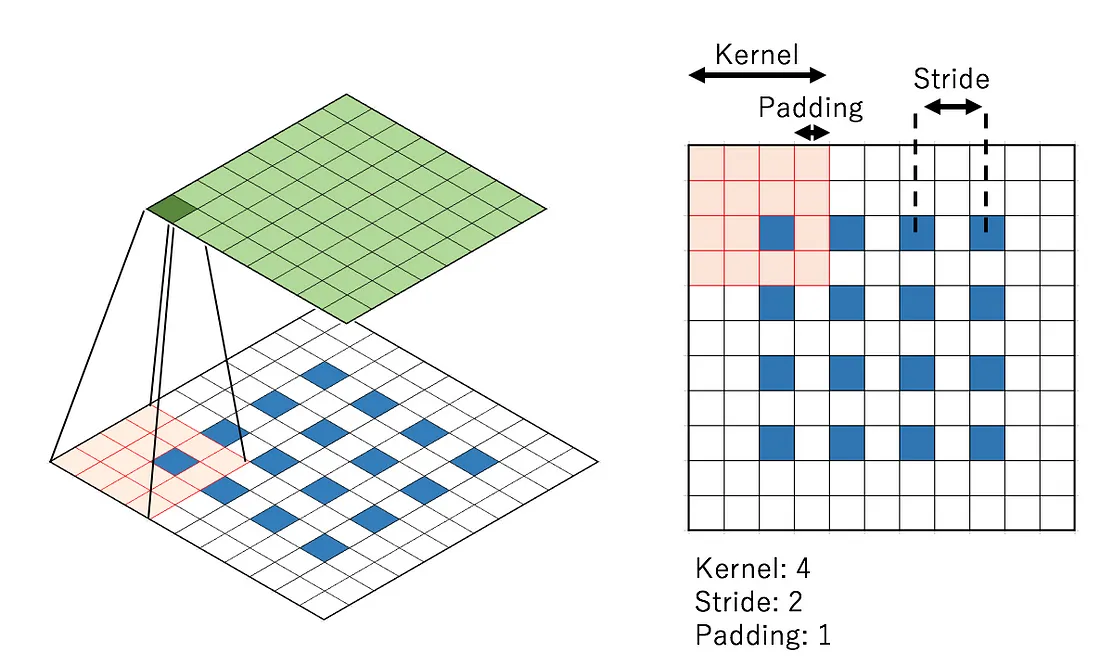

# Leaky ReLU over ReLU
### Unlike ReLU, LeakyReLU allows a certain amount to slide out. This enables the neurons to remain active. If ReLU was used, it would have caused the output of neurons to be zero leading to ‘dead neurons

#### Training This is where GANs get interesting. The GAN starts min-max games of the Generator and the Discriminator. At first, we send noise to the Generator to generate an image. Real Images are sent to Discriminator and loss is found for that case. Similarly, we do it for fake images. Finally, we find the overall discriminator loss by taking the mean out.



In [17]:
class DCGAN():
    def __init__(self, rows, cols, channels, z=100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        optimizer = Adam(0.0002, 0.5, 0.99)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(512 * 7 * 7, activation="relu", input_dim=self.latent_dim))  # connect the input to dense layer
        model.add(Reshape((7, 7, 512)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same", activation='tanh'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(1024, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        fig.suptitle(f'Epoch : {epoch} G:512,256,128 | D:128,256,512,1024 |\n| lr:0.002 ', fontsize=12)
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        os.makedirs('DCGAN RELU', exist_ok=True)
        fig.savefig("DCGAN RELU/DCGAN_{:d}.png".format(epoch))
        plt.close()

    def train(self, epochs, batch_size=1024, save_interval=1):
        # Load the dataset
        X_train = X_pre
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        batches_per_epoch = X_train.shape[0] // batch_size
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):

                # ---------------------
                # Train Discriminator
                # ---------------------
                # Select a random half of images
                for _ in range(2):
                    idx = np.random.randint(0, X_train.shape[0], batch_size)
                    imgs = X_train[idx]
                    # Sample noise and generate a batch of new images
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    gen_imgs = self.generator.predict(noise)
                    # Train the discriminator (real classified as ones
                    # and generated as zeros)
                    self.discriminator.trainable = True
                    d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                    d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                    # ---------------------
                    # Train Generator
                    # ---------------------
                    self.discriminator.trainable = False
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                print("Epoch: %d/%d  Batch Size: %d/%d [loss: %f, acc.: %.2f%%] [G loss: %f]" % (
                epoch, epochs, batch, batches_per_epoch, d_loss[0], 100 * d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)


In [18]:
dcgan_Improved = DCGAN(28,28,1)
dcgan_Improved.train(epochs=200, batch_size=1024, save_interval=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 7, 7, 256)         295168    
                                                                 
 batch_normalization_9 (Batc  (None, 7, 7, 256)        1024      
 hNormalization)                                      

# Data Augementation
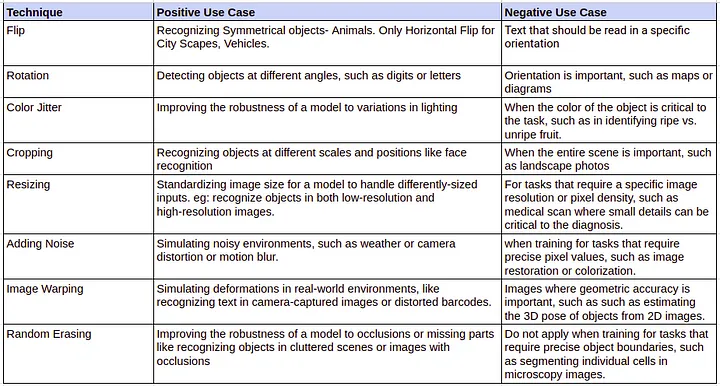

- 6.1. Rotation
    -   The input data is rotated right or left on an axis between 1° and 359°. The rotation degree parameter has a significant impact on the safety of the dataset. For example, on digit identification tasks like MNIST, slight rotations like 1 to 20 or −1 to −20 could be useful, but when the rotation degree increases, properly the CNN network cannot accurately distinguish between some digits.
    -   +- 15 Degrees
    

- 6.3. Shifting
    -   The input image is shifting right, left, up, or down. This transformation is a highly effective adjustment to prevent positional bias. Figure 7 shows an example of shifting data augmentation technique using Arabic alphabet characters.
    -   +- 2 Pixels


- Made each class equal

https://onlinelibrary.wiley.com/doi/10.1155/2022/9965426

In [ ]:
max_count = df[0].value_counts().max()

# Function to augment images
def augment_image(image):
    # Rotation
    angle = random.uniform(-15, 15)  # Rotate between -15 to 15 degrees
    rotated_image = rotate(image, angle, reshape=False)
    # Shifting
    shift_val = random.uniform(-2, 2)  # Shift between -2 to 2 pixels
    shifted_image = shift(rotated_image, shift=(shift_val, shift_val, 0), mode='nearest')
    return shifted_image

# Augment the dataset to balance the number of samples per label
balanced_X = []
balanced_y = []

for label in np.unique(y_pre):
    label_indices = np.where(y_pre == label)[0]
    label_images = X_pre[label_indices]
    
    # Check if there are no images for the current label
    if len(label_images) == 0:
        continue
    
    # If the number of samples is less than max_count, augment the images
    if len(label_images) < max_count:
        augmented_images = []
        for i in range(max_count - len(label_images)):
            img = label_images[i % len(label_images)]
            augmented_images.append(augment_image(img))
        label_images = np.concatenate((label_images, augmented_images), axis=0)
    
    balanced_X.extend(label_images)
    balanced_y.extend([label] * max_count)

# Convert to numpy arrays
balanced_X = np.array(balanced_X)
balanced_y = np.array(balanced_y)

print(f"Original dataset shape: {X_pre.shape}")
print(f"Balanced dataset shape: {balanced_X.shape}")
print(f"Labels distribution: {np.unique(balanced_y, return_counts=True)}")

In [ ]:
class DCGAN():
    def __init__(self, rows, cols, channels, z=100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        optimizer = Adam(0.0002, 0.5, 0.99)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):
        model = Sequential()
        model.add(Dense(512 * 7 * 7, activation="relu", input_dim=self.latent_dim))  # connect the input to dense layer
        model.add(Reshape((7, 7, 512)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same", activation='tanh'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential()
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(1024, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def save_imgs(self, epoch):
        r, c = 10, 10
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        fig.suptitle(f'Epoch : {epoch} G:512,256,128 | D:128,256,512,1024 |\n| lr:0.0002 ', fontsize=12)
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        os.makedirs('AUG DCGAN', exist_ok=True)
        fig.savefig("AUG DCGAN/DCGAN_{:d}.png".format(epoch))
        plt.close()

    def train(self, epochs, batch_size=1024, save_interval=1):
        # Load the dataset
        X_train = balanced_X
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        batches_per_epoch = X_train.shape[0] // batch_size
        for epoch in range(epochs):
            for batch in range(batches_per_epoch):

                # ---------------------
                # Train Discriminator
                # ---------------------
                # Select a random half of images
                for _ in range(2):
                    idx = np.random.randint(0, X_train.shape[0], batch_size)
                    imgs = X_train[idx]
                    # Sample noise and generate a batch of new images
                    noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                    gen_imgs = self.generator.predict(noise)
                    # Train the discriminator (real classified as ones
                    # and generated as zeros)
                    self.discriminator.trainable = True
                    d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                    d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                    # ---------------------
                    # Train Generator
                    # ---------------------
                    self.discriminator.trainable = False
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                g_loss = self.combined.train_on_batch(noise, valid)

                # Plot the progress
                print("Epoch: %d/%d  Batch Size: %d/%d [loss: %f, acc.: %.2f%%] [G loss: %f]" % (
                epoch, epochs, batch, batches_per_epoch, d_loss[0], 100 * d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)


In [ ]:
aug_dcgan = DCGAN(28,28,1)
aug_dcgan.train(epochs=200, batch_size=1024, save_interval=1)